## Persistence model with Kafka and Spark streaming 

This notebook provides an example of a persistent model on streaming data coming from a Kafka producer. 

This notebook uses 
* the [Python client for the Apache Kafka distributed stream processing system](http://kafka-python.readthedocs.io/en/master/index.html) to receive messages from a Kafka cluster. 
* [Spark streaming](https://spark.apache.org/docs/latest/streaming-programming-guide.html) for processing the streaming data


### General import

In [1]:
import time
import re, ast
import numpy as np
import os

import findspark
findspark.init()

### Start Spark session


In [2]:
from pyspark.sql import SparkSession
from pyspark.streaming import StreamingContext
from pyspark.streaming.kafka import KafkaUtils


os.environ['PYSPARK_SUBMIT_ARGS'] = '--master local[*] pyspark-shell'

spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("KafkaReceive") \
    .getOrCreate()

### Connect to Kafka server on topic persistence

In [3]:
#This function creates a connection to a Kafka stream
#You may change the topic, or batch interval
#The Zookeeper server is assumed to be running at 127.0.0.1:2181
#The function returns the Spark context, Spark streaming context, and DStream object
def getKafkaDStream(spark,topic='persistence',batch_interval=10):

    #Get Spark context
    sc=spark.sparkContext

    #Create streaming context, with required batch interval
    ssc = StreamingContext(sc, batch_interval)

    #Checkpointing needed for stateful transforms
    ssc.checkpoint("checkpoint")
    
    #Create a DStream that represents streaming data from Kafka, for the required topic 
    dstream = KafkaUtils.createStream(ssc, "zoo1:2181,zoo2:2181,zoo3:2181", "spark-streaming-consumer", {topic: 1})
    
    return [sc,ssc,dstream]


In [4]:
#Update function: new_values are the set of values received during the batch interval, state is the current state
#The state is assumed to be a list of two values: the last temperature, and output data for day 8 (predictions, truth, seconds)
#The function estimates the prediction error on the set of new values, and update the state for the persistence model
def updateFunction(new_values, states):
    for state in states:
        last_temperature=state[0]
        sensorToPredict=state[1]
        output_day8=state[2]

        if len(new_values)>0 :
            #Transforms list of values into an array
            array_values=np.array(new_values)

            #if day 8
            if np.floor(array_values[0][1] / 86400)==7:

                predictions=[]
                truth=[]
                seconds=[]

                #Go through all measurements
                for i in range(0,array_values.shape[0]):

                    if array_values[i,2]==sensorToPredict:
                        #With persistence, the model is the last temperature for sensor 1 observed in the last batch
                        predictions.append(last_temperature)

                        truth.append(array_values[i,0])
                        seconds.append(array_values[i,1])

                    #else:
                        #Possibly adapt model. Add code here to adapt model if you use masurements from other sensors.

                #Store data in state
                output_day8=[predictions,truth,seconds]

            else:
                if array_values[0][1] % 86400<8:
                    #Before day 8, adapt your model with measurements of the current batch
                    #For persistence model this is simply keeping the last measurement for sensor 1
                    #Note: Below is a code for a more general case, for illustration purposes, 
                    #where there may be sensors other than sensor 1, and a loop other all input values may be necessary
                    for i in range(0,array_values.shape[0]):

                        if array_values[i,2]==sensorToPredict:
                            current_temperature=np.float(array_values[i,0])

                    last_temperature=current_temperature

        #Update state
        state=[last_temperature,sensorToPredict,output_day8]
    #state is now the last received measurement
    return states

### Define streaming pipeline

* We define one state, which is a list of two elements:
    * The last measurement
    * The output of predictions for sensor 1 for day 8
* We create a DStream, flat map with the sensor ID as key, update state for the stream, and save MSE

In [5]:
#Helper functions

#Print number of partitions and number of records for an RDD
def printInfoRDD(rdd):
    if rdd is not None:
        print("The RDD has "+str(rdd.getNumPartitions())+" partitions")
        print("The RDD has "+str(rdd.count())+" elements")
    else:
        print("No info to provide")
        
#Save state in global Python variable
def saveState(rdd):
    global state_global
    if rdd is not None:
        data=rdd.collect()
        state_global=data
        


In [6]:
#Initial state
last_measurement=0
sensorToPredict=1
output_day8=None

state1=[last_measurement,sensorToPredict,output_day8]
state24=[0,24,None]
state = [state1, state24]
#Batch interval (to be synchronized with KafkaSend)
interval=10

#This variable is used to retrieve state data (through saveState function)
state_global=None

#Create dtsream
[sc,ssc,dstream]=getKafkaDStream(spark=spark,topic='persistence',batch_interval=interval)

#Evaluate string content (a list) and cast as float value

dstream = dstream.map(lambda x: np.array(ast.literal_eval(x[1])))
#Use this for debugging

#Group by sensor id. x[2] is here the sensorId (for example '1'), and x are the sensor measurement, seconds, sensorId and sensor type)
dstream=dstream.flatMap(lambda x: [(x[2],x)])
dstream.foreachRDD(printInfoRDD)
#Use this for debugging
#dstream.pprint()

initialStateRDD = sc.parallelize(state)
print(initialStateRDD.collect())
print("Number of partitions for StateRDD: "+str(initialStateRDD.getNumPartitions()))

state_stream=dstream.updateStateByKey(updateFunction,initialRDD=initialStateRDD)
      
state_stream.foreachRDD(printInfoRDD)
state_stream.foreachRDD(saveState)
#Use this for debugging
#dstream.pprint()

[[0, 1, None], [0, 24, None]]
Number of partitions for StateRDD: 4


### Start streaming application

In [20]:
#from kafka import KafkaConsumer
#consumer = KafkaConsumer('persistence', bootstrap_servers='kafka:9092')
#for msg in consumer:
#    print (len(msg))

In [7]:
#For synchronization with receiver (for the sake of the simulation), starts at a number of seconds multiple of five
current_time=time.time()
time_to_wait=interval-current_time%interval
time.sleep(time_to_wait)

ssc.start()

The RDD has 0 partitions
The RDD has 0 elements
The RDD has 4 partitions
The RDD has 0 partitions
The RDD has 0 elements
The RDD has 4 partitions
The RDD has 0 partitions
The RDD has 0 elements
The RDD has 4 partitions
The RDD has 0 partitions
The RDD has 0 elements
The RDD has 4 partitions
The RDD has 0 partitions
The RDD has 0 elements
The RDD has 4 partitions
The RDD has 0 partitions
The RDD has 0 elements
The RDD has 4 partitions
The RDD has 0 partitions
The RDD has 0 elements
The RDD has 4 partitions
The RDD has 0 partitions
The RDD has 0 elements
The RDD has 4 partitions
The RDD has 0 partitions
The RDD has 0 elements
The RDD has 4 partitions
The RDD has 5 partitions
The RDD has 3045 elements
The RDD has 4 partitions
The RDD has 4 partitions
The RDD has 1921 elements
The RDD has 4 partitions
The RDD has 4 partitions
The RDD has 2008 elements
The RDD has 4 partitions


### Stop streaming

In [15]:
#Wait to receive all data up to day 8 before stopping
ssc.stop(stopSparkContext=False,stopGraceFully=False)

The RDD has 0 partitions
The RDD has 0 elements
The RDD has 4 partitions


## Collect results, plot predictions, compute MSE

In [8]:
#For plots
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode()


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


The RDD has 3 partitions
The RDD has 1868 elements
The RDD has 4 partitions


In [10]:
# Check content
state1

[0, 1, None]

The RDD has 3 partitions
The RDD has 1824 elements
The RDD has 4 partitions
The RDD has 4 partitions
The RDD has 2049 elements
The RDD has 4 partitions
The RDD has 4 partitions
The RDD has 2136 elements
The RDD has 4 partitions
The RDD has 0 partitions
The RDD has 0 elements
The RDD has 4 partitions
The RDD has 0 partitions
The RDD has 0 elements
The RDD has 4 partitions


In [12]:
#Predictions, truth, seconds
len(state_global[0][1][2])

TypeError: object of type 'NoneType' has no len()

The RDD has 0 partitions
The RDD has 0 elements
The RDD has 4 partitions
The RDD has 0 partitions
The RDD has 0 elements
The RDD has 4 partitions
The RDD has 0 partitions
The RDD has 0 elements
The RDD has 4 partitions
The RDD has 0 partitions
The RDD has 0 elements
The RDD has 4 partitions
The RDD has 0 partitions
The RDD has 0 elements
The RDD has 4 partitions
The RDD has 0 partitions
The RDD has 0 elements
The RDD has 4 partitions
The RDD has 0 partitions
The RDD has 0 elements
The RDD has 4 partitions
The RDD has 0 partitions
The RDD has 0 elements
The RDD has 4 partitions
The RDD has 0 partitions
The RDD has 0 elements
The RDD has 4 partitions
The RDD has 0 partitions
The RDD has 0 elements
The RDD has 4 partitions
The RDD has 0 partitions
The RDD has 0 elements
The RDD has 4 partitions
The RDD has 0 partitions
The RDD has 0 elements
The RDD has 4 partitions
The RDD has 0 partitions
The RDD has 0 elements
The RDD has 4 partitions
The RDD has 0 partitions
The RDD has 0 elements
The

In [12]:
#Retrieve day 8 data from the state
[predictions,truth,seconds]=state_global[0][1][2]

The RDD has 0 partitions
The RDD has 0 elements
The RDD has 4 partitions
The RDD has 1 elements


In [13]:
MSE=np.mean((np.array(truth)-np.array(predictions))**2)
print("MSE of model on day 8: "+str(MSE))

MSE of model on day 8: 13.881520749
The RDD has 0 partitions
The RDD has 0 elements
The RDD has 4 partitions
The RDD has 1 elements


In [17]:
trace_truth = go.Scatter(
    y = truth,
    x = seconds,
    name="Truth"
)

trace_predictions = go.Scatter(
    y = predictions,
    x = seconds,
    name="Predictions"
)

layout= go.Layout(
    title= 'Truth and predictions for sensor 1, day 8<br>Persistence model <br>'+\
            'Mean square error: '+str(MSE),
    xaxis= dict(
        title= 'Time (seconds)',
    ),
    yaxis=dict(
        title= 'Temperature',
    ),
    showlegend= True
)

fig= go.Figure(data=[trace_truth,trace_predictions], layout=layout)
iplot(fig)


The RDD has 1 elements


The RDD has 3 partitions
The RDD has 1868 elements
The RDD has 4 partitions
The RDD has 1 elements
The RDD has 3 partitions
The RDD has 1741 elements
The RDD has 4 partitions
The RDD has 1 elements
The RDD has 4 partitions
The RDD has 1824 elements
The RDD has 4 partitions
The RDD has 1 elements
The RDD has 3 partitions
The RDD has 2049 elements
The RDD has 4 partitions
The RDD has 1 elements
The RDD has 4 partitions
The RDD has 2136 elements
The RDD has 4 partitions
The RDD has 1 elements
The RDD has 0 partitions
The RDD has 0 elements
The RDD has 4 partitions
The RDD has 1 elements
The RDD has 0 partitions
The RDD has 0 elements
The RDD has 4 partitions
The RDD has 1 elements
The RDD has 0 partitions
The RDD has 0 elements
The RDD has 4 partitions
The RDD has 1 elements
The RDD has 0 partitions
The RDD has 0 elements
The RDD has 4 partitions
The RDD has 1 elements
The RDD has 0 partitions
The RDD has 0 elements
The RDD has 4 partitions
The RDD has 1 elements
The RDD has 0 partitions


The RDD has 0 partitions
The RDD has 0 elements
The RDD has 4 partitions
The RDD has 0 partitions
The RDD has 0 elements
The RDD has 4 partitions
The RDD has 0 partitions
The RDD has 0 elements
The RDD has 4 partitions
The RDD has 0 partitions
The RDD has 0 elements
The RDD has 4 partitions
The RDD has 0 partitions
The RDD has 0 elements
The RDD has 4 partitions
The RDD has 0 partitions
The RDD has 0 elements
The RDD has 4 partitions
The RDD has 0 partitions
The RDD has 0 elements
The RDD has 4 partitions
The RDD has 0 partitions
The RDD has 0 elements
The RDD has 4 partitions
The RDD has 0 partitions
The RDD has 0 elements
The RDD has 4 partitions
The RDD has 0 partitions
The RDD has 0 elements
The RDD has 4 partitions
The RDD has 0 partitions
The RDD has 0 elements
The RDD has 4 partitions
The RDD has 0 partitions
The RDD has 0 elements
The RDD has 4 partitions
The RDD has 0 partitions
The RDD has 0 elements
The RDD has 4 partitions
The RDD has 0 partitions
The RDD has 0 elements
The

----------------------------------------
Exception happened during processing of request from ('127.0.0.1', 39030)
Traceback (most recent call last):
  File "/root/anaconda3/lib/python3.6/socketserver.py", line 317, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/root/anaconda3/lib/python3.6/socketserver.py", line 348, in process_request
    self.finish_request(request, client_address)
  File "/root/anaconda3/lib/python3.6/socketserver.py", line 361, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/root/anaconda3/lib/python3.6/socketserver.py", line 721, in __init__
    self.handle()
  File "/usr/local/spark-2.2.1/python/pyspark/accumulators.py", line 235, in handle
    num_updates = read_int(self.rfile)
  File "/usr/local/spark-2.2.1/python/pyspark/serializers.py", line 581, in read_int
    raise EOFError
EOFError
----------------------------------------


In [15]:
%matplotlib inline
import matplotlib.pyplot as plt


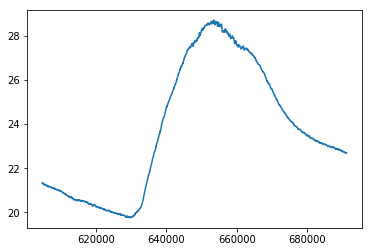

The RDD has 0 partitions
The RDD has 0 elements
The RDD has 4 partitions
The RDD has 1 elements
The RDD has 0 partitions
The RDD has 0 elements
The RDD has 4 partitions
The RDD has 1 elements
The RDD has 0 partitions
The RDD has 0 elements
The RDD has 4 partitions
The RDD has 1 elements
The RDD has 0 partitions
The RDD has 0 elements
The RDD has 4 partitions
The RDD has 1 elements
The RDD has 0 partitions
The RDD has 0 elements
The RDD has 4 partitions
The RDD has 1 elements
The RDD has 5 partitions
The RDD has 3045 elements
The RDD has 4 partitions
The RDD has 1 elements
The RDD has 3 partitions
The RDD has 1921 elements
The RDD has 4 partitions
The RDD has 1 elements
The RDD has 4 partitions
The RDD has 2008 elements
The RDD has 4 partitions


In [16]:
plt.plot(seconds,truth)